In [1]:
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

from data.default_dataset import DefaultDataset
from models.faster_vqa import FasterVQA

加载模型和权重

In [2]:
weight_path = '/home/ly/code/LinVQATools/faster_vqa/change/best_SROCC_epoch_230.pth'
weight = torch.load(weight_path)['state_dict']
model_dict = dict(backbone_size='swin_tiny_grpb',
    backbone={"fragments": dict(window_size=(4, 4, 4))},
    backbone_preserve_keys='fragments')
model = FasterVQA(**model_dict)
model.load_state_dict(weight)
print(model)

swin_tiny_grpb


/home/ly/anaconda3/envs/torch1.13/lib/python3.8/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


None False
Setting backbone: fragments_backbone
FasterVQA(
  (data_preprocessor): BaseDataPreprocessor()
  (model): DiViDeAddEvaluator(
    (fragments_backbone): SwinTransformer3D(
      (patch_embed): PatchEmbed3D(
        (proj): Conv3d(3, 96, kernel_size=(2, 4, 4), stride=(2, 4, 4))
        (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      )
      (pos_drop): Dropout(p=0.0, inplace=False)
      (layers): ModuleList(
        (0): BasicLayer(
          (blocks): ModuleList(
            (0): SwinTransformerBlock3D(
              (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
              (attn): WindowAttention3D(
                (qkv): Linear(in_features=96, out_features=288, bias=True)
                (attn_drop): Dropout(p=0.0, inplace=False)
                (proj): Linear(in_features=96, out_features=96, bias=True)
                (proj_drop): Dropout(p=0.0, inplace=False)
                (softmax): Softmax(dim=-1)
              )
              (dro

加载验证集

In [3]:
dataset_dict = dict(anno_reader='ODVVQAReader',
        prefix='temp/fragment',
        phase='test',
        split_file='/home/ly/code/LinVQATools/data/odv_vqa/tr_te_VQA_ODV.txt',
        frame_sampler=dict(
            name='FragmentSampleFrames',
            fsize_t=32 // 8,
            fragments_t=8,
            clip_len=32,
            frame_interval=2,
            t_frag=8,
            num_clips=1,
        ),
        spatial_sampler=dict(
            name='PlaneSpatialFragmentSampler',
            fragments_h=7,
            fragments_w=7,
            fsize_h=32,
            fsize_w=32,
            aligned=8,
        ))
dataset = DefaultDataset(**dataset_dict)
dataloader = DataLoader(dataset=dataset,batch_size=1,num_workers=4,shuffle=False)

07/08 18:55:13 - mmengine - WARNING - anno_root参数未找到，默认为/home/ly/code/LinVQATools/data/odv_vqa


In [4]:
y = []
y_pred = []
model = model.cuda()
for item in tqdm(dataloader):
    inputs = item['inputs'].cuda()
    result = model(inputs,gt_label=item['gt_label'],mode='predict')
    y_pred.append(result[0])
    y.append(result[1])

  0%|          | 0/108 [00:00<?, ?it/s]

8 7 7


/home/ly/anaconda3/envs/torch1.13/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")
100%|██████████| 108/108 [01:18<00:00,  1.37it/s]


In [5]:
from scipy.stats import spearmanr

y_pred = torch.stack(y_pred,dim=0).flatten().cpu().detach().numpy()
y = torch.stack(y,dim=0).flatten().numpy()
s = spearmanr(y, y_pred)[0]
print(s)

0.8558785141997008


In [6]:
print(y)
print(y_pred)
print(y-y_pred*10)

[0.51132804 0.5121804  0.3778674  0.5966643  0.52622783 0.38351288
 0.5757952  0.55957365 0.4351227  0.6646226  0.5567569  0.29488623
 0.6628805  0.522985   0.25827035 0.62213933 0.5569207  0.32290414
 0.5357787  0.47965592 0.32013595 0.5746439  0.46648276 0.3666844
 0.5680887  0.5283015  0.47307777 0.57668144 0.49099138 0.3588439
 0.5733949  0.45492408 0.28146625 0.5985142  0.46595427 0.2991815
 0.56138104 0.50505793 0.44462454 0.53615963 0.44455922 0.44559354
 0.56366974 0.4463708  0.48651758 0.58086497 0.5357705  0.4452538
 0.61498195 0.5618573  0.4033826  0.5898661  0.61411136 0.50728554
 0.5738605  0.59103864 0.4383474  0.573973   0.51360047 0.44698453
 0.62682134 0.5736339  0.46532336 0.6036083  0.48774067 0.35964543
 0.61667264 0.4382963  0.26264408 0.62269986 0.5554357  0.4467364
 0.63419855 0.5647622  0.30006748 0.6116221  0.5409302  0.20384605
 0.646545   0.5678368  0.24719436 0.55914426 0.40730527 0.2633503
 0.60309356 0.388904   0.26027983 0.62979597 0.4799649  0.3261121
 0

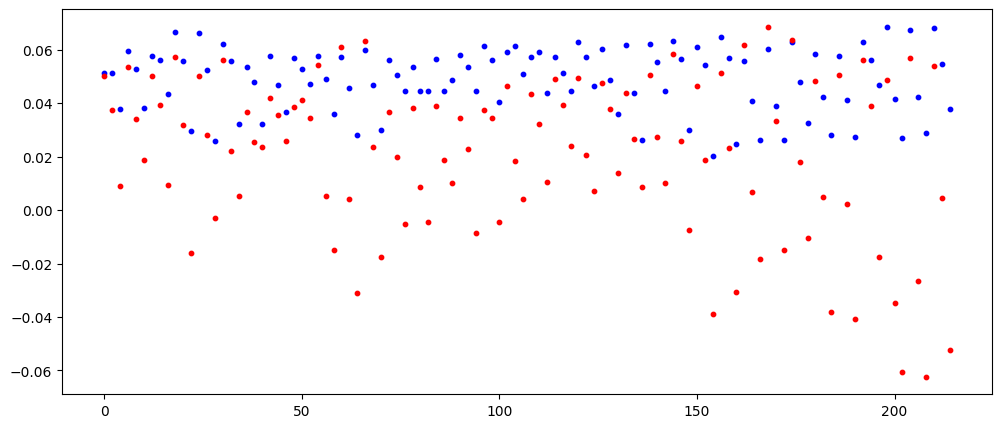

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 5))
plt.scatter(x=[i for i in range(0,2*len(y),2)],y=y/10,c='b',s=10)
plt.scatter(x=[i for i in range(0,2*len(y_pred),2)],y=y_pred,c='r',s=10)